# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28.09.2025   | Adrienne | Update | Creating models |
| 05.10.2025 | Adrienne | Update | Created baseline model with KMeans |
| 07.10.2025 | Adrienne | Update | Added code for wordcloud visualization |
| 12.10.2025 | Adrienne | Update | Finshing modeling using TF-IDF encoded data 

# Content

* [Introduction](#introduction)

In [216]:
import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
import setuptools
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


## Load Data

In [ ]:
# readin in patient level file label encoded
path = "../data/clean"
df = pd.read_pickle(f"{path}/patient_level_features.pkl")

In [229]:
df.head()

,gender,age,number_of_claims,preventative_care_ind,total_value,G9857,G9708,S0605,G0153,G0464,...,G0157,HCPCS_level_1,HCPCS_level_2,National_Codes_Established_for_State_Medicaid_Agencies,Evaluation_and_Management_(E/M)_Codes_,Temporary_Codes,Temporary_National_Codes_(Non-Medicare),Procedures/Professional_Services,Alcohol_and_Drug_Abuse_Treatment,Outpatient_PPS
0,0,79.0,18,1,149.37,0.0,0.0,0.0,0.0,0.279341,...,0.0,0.665558,0.746346,0.0,0.665558,0.0,0.0,0.746346,0.0,0.0
1,1,75.0,17,1,234.72,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.892770,0.450512,0.0,0.892770,0.0,0.0,0.450512,0.0,0.0
2,0,77.0,29,1,85.55,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.938776,0.344529,0.0,0.938776,0.0,0.0,0.344529,0.0,0.0
3,0,78.0,24,1,21901.40,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.855392,0.517980,0.0,0.855392,0.0,0.0,0.517980,0.0,0.0
4,1,80.0,19,1,8388.69,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.313617,0.949550,0.0,0.313617,0.0,0.0,0.949550,0.0,0.0


In [218]:
# readin icd10 mapper
mapper_path = "../data/mappers"
icd10_mapper = pd.read_pickle(f"{mapper_path}/icd10.pkl")

## Introduction - Model Development

We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared.  Initially, we encoded the data using labels, but when running the first Kmeans model, we realized that the missings created by that feature encoding method was not surprisingly giving very poor results.  We then switched to TD-IDF encoding and got much better and useful results.

### Creating Helper Functions

In [219]:
def standardize_features(dataset):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dataset)
    return X_scaled

In [278]:

def dim_red_PCA(n_components, dataset):
    
    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(dataset)

# Calculate the explained variance ratio
    explained_variance_ = pca.explained_variance_
    explained_variance_ratio_ = pca.explained_variance_ratio_
    c_sum = np.cumsum(explained_variance_ratio_) 
    pc_components = np.arange(pca.n_components_) + 1
    c_sum_df = pd.DataFrame(zip(pc_components, c_sum), columns=['Principal Component', 'Cummulative Explained Variance'])
    print(c_sum_df)
    
    return pca, X_pca, explained_variance_, c_sum_df

In [275]:
def create_scree_plot(pca, explained_variance_):
    eigenvalues = pca.explained_variance_
    prop_var = eigenvalues / np.sum(eigenvalues)
    pc_numbers = np.arange(pca.n_components_) + 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
    
    #plt.figure(figsize=(5, 4)) 
    ax1.plot(
             pc_numbers, 
             eigenvalues, 
            'b.-')
    
    ax1.axhline(y=1, color='r', linestyle='--')
    ax1.set_title('Figure 1: Scree Plot for Eigenvalues', fontsize=8)
    ax1.set_ylabel('Eigenvalues', fontsize=8)
    ax1.set_xlabel('Principal Component', fontsize=8)
    
#     ax1.set_xticks(fontsize=6)
#     ax1.set_yticks(fontsize=6)

    ax2.plot(
             pc_numbers, 
             prop_var, 
            'b.-')
    
    ax2.set_title('Figure 2: Scree Plot for Proportion of Variance Explained', fontsize=8)
    ax2.set_ylabel('Proportion of Variance Explained', fontsize=8)
    ax2.set_xlabel('Principal Component', fontsize=8)
#     ax2.set_xticks(fontsize=6)
#     ax2.set_yticks(fontsize=6)

    # plt.plot(
    #          pc_numbers, 
    #          eigenvalues, 
    #         'b.-')
    
    # plt.axhline(y=1, color='r', linestyle='--')
    # plt.title('Figure 1: Scree Plot', fontsize=8)
    # plt.ylabel('Proportion of Variance', fontsize=8)
    # plt.xticks(fontsize=6)
    # plt.yticks(fontsize=6)

    plt.show()
    
    return None 

In [222]:

def feature_importance(pca, dataset):
    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on EACH component i.e. largest absolute value
    # using LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = dataset.columns

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # using LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
   
    return dic

In [223]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
        
    colors = cm.jet( (labels.astype(float) ) / (n_clusters))
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
        # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        axis.scatter(c[0], c[1], 
                marker="$%d$" % i, 
                alpha=1, s=20, 
                color = cm.jet( (i ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [224]:
def calculate_silhouette_score(X_pca, labels, metric):
    # works for all sklearn unsupervised model evaluation metrics with DBSCAN
    score = silhouette_score(X_pca, labels, metric= metric)
    print('Silhouetter Score: %.3f' % score)
    return score

In [225]:
def create_elbow_plot(cluster_range_start, cluster_range_end, X_pca):
    wcss = []
    for i in range(cluster_range_start, cluster_range_end):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X_pca)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(3, 3)) 
    plt.plot(range(cluster_range_start, cluster_range_end), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

### Baseline Model - KMeans
Steps: 
- standardize features
- reduce features using PCA
- use Scree plot to find optimal number of components
- create KMeans model
- find optimal number of clusters using Silhouette and Elbow methods
- examine most important feature by principal component
- create graph of clusters with first two principal components
- optimize any model inputs

## KMeans using TF-IDF Encoded Data

Standardizing Features

In [226]:
# Standardize the features
X_scaled = standardize_features(df)

Dimensionality Reduction using Principal Component Analysis

In [279]:
# Perform PCA
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(14, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.238044
1                     2                        0.345932
2                     3                        0.402755
3                     4                        0.457377
4                     5                        0.495894
5                     6                        0.529516
6                     7                        0.561248
7                     8                        0.591198
8                     9                        0.619861
9                    10                        0.646433
10                   11                        0.667248
11                   12                        0.687152
12                   13                        0.705734
13                   14                        0.723894


Scree Plot - to Analyze Optimal PCA Components

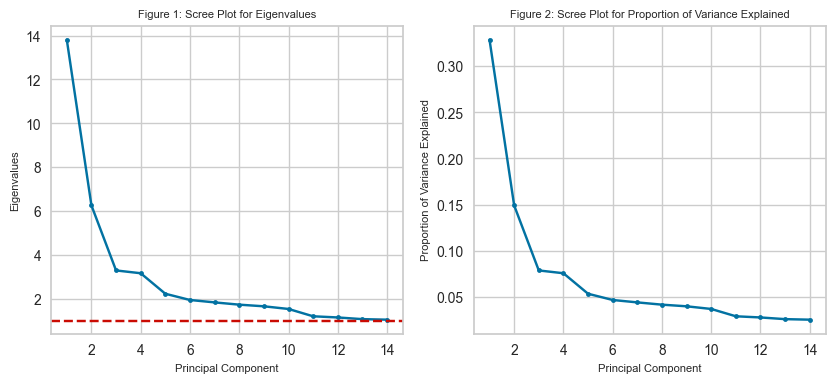

In [276]:
create_scree_plot(pca, explained_variance_)

In [280]:
# Final PCA
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(5, X_scaled)

   Principal Component  Cummulative Explained Variance
0                    1                        0.238044
1                    2                        0.345932
2                    3                        0.402755
3                    4                        0.457377
4                    5                        0.495894


In [281]:
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(11, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.238044
1                     2                        0.345932
2                     3                        0.402755
3                     4                        0.457377
4                     5                        0.495894
5                     6                        0.529516
6                     7                        0.561248
7                     8                        0.591198
8                     9                        0.619861
9                    10                        0.646433
10                   11                        0.667248


In [284]:
# kmeans code
kmeans = KMeans(init = 'k-means++', n_clusters=9, n_init= 5, random_state = 10) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

# add cluster results to dataset
df['cluster'] = labels

In [283]:
# quick look at cluster values
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
6,27.886460
1,24.204066
0,23.935558
2,11.430763
3,8.016878
5,2.032988
7,1.380898
4,0.920598
8,0.191791


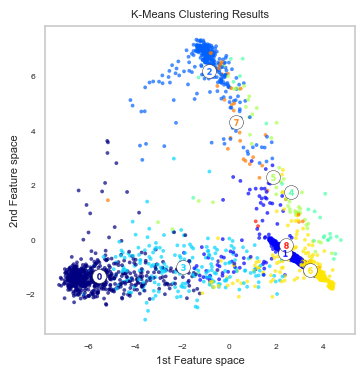

In [285]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 9, X_pca, km, ax, model_type = 'km')

Calculate Silhouette Score

In [286]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
sil_score = calculate_silhouette_score(X_pca, labels, 'euclidean')
sil_score = calculate_silhouette_score(X_pca, labels, 'cosine')

Silhouetter Score: 0.475
Silhouetter Score: 0.664


Create Silhouette Plot

Silhouetter Score: 0.475
For n_clusters = 7 The average silhouette_score using euclidean is : 0.4745003849259973


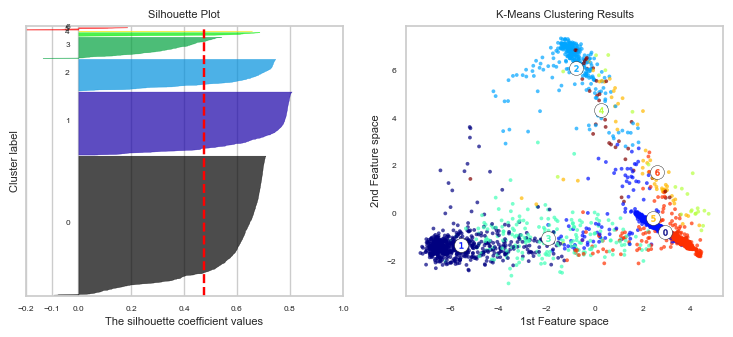

Silhouetter Score: 0.475
For n_clusters = 8 The average silhouette_score using euclidean is : 0.4745003849259973


<Figure size 800x550 with 0 Axes>

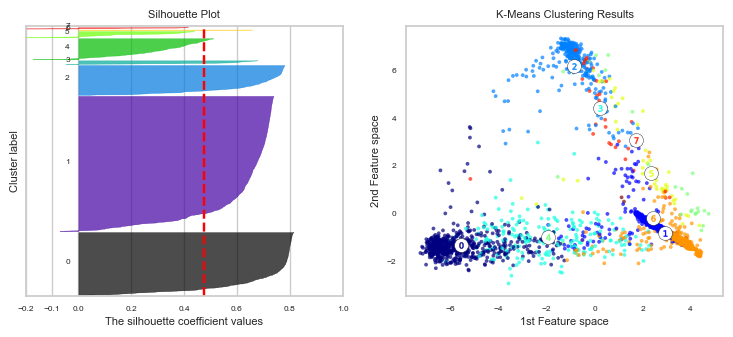

Silhouetter Score: 0.475
For n_clusters = 9 The average silhouette_score using euclidean is : 0.4745003849259973


<Figure size 800x550 with 0 Axes>

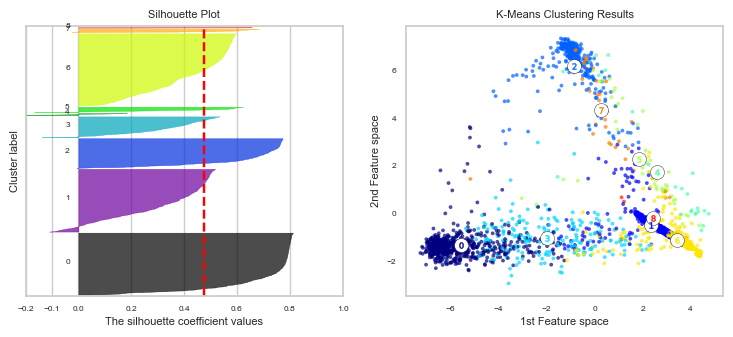

Silhouetter Score: 0.475
For n_clusters = 10 The average silhouette_score using euclidean is : 0.4745003849259973


<Figure size 800x550 with 0 Axes>

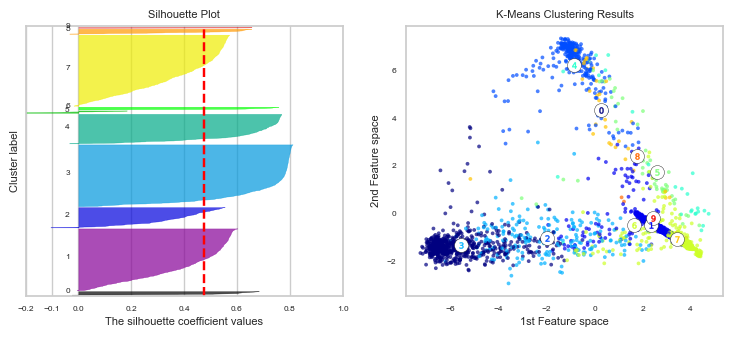

Silhouetter Score: 0.475
For n_clusters = 11 The average silhouette_score using euclidean is : 0.4745003849259973


<Figure size 800x550 with 0 Axes>

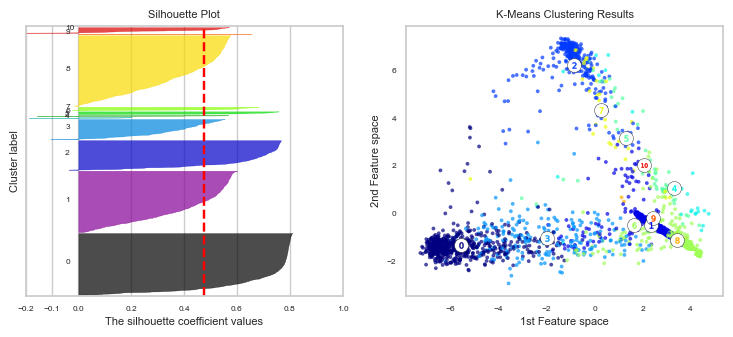

<Figure size 800x550 with 0 Axes>

In [290]:
range_n_clusters = [7, 8, 9, 10, 11]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(9, 3.5))
    
    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    km = KMeans(init = 'k-means++', n_clusters=n_clusters, n_init = 5, random_state=10)
    cluster_labels = km.fit_predict(X_pca)

    #silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_avg = calculate_silhouette_score(X_pca, labels, 'euclidean')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score using euclidean is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='x', labelsize=6)

    # 2nd Plot showing the actual clusters formed
    create_cluster_plot(labels, n_clusters, X_pca, km, ax2, model_type = 'km')

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=8,
        fontweight="bold",
    )

plt.show()

Elbow Method

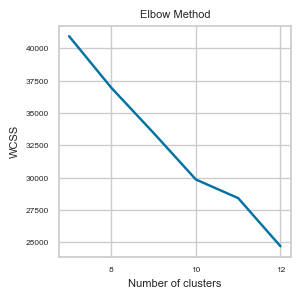

In [201]:
create_elbow_plot(7, 13, X_pca)

In [ ]:
# LSA/Truncated SVD Dimension Reduction
maxDimensions = min(df.shape)-1

# The "arpack" algorithm is typically more efficient for large sparse matrices compared to the default "randomized" algorithm
svdmodel = TruncatedSVD(n_components=maxDimensions, algorithm="arpack") 

lsa = svdmodel.fit_transform(df)

print(lsa)

In [473]:
df.head()

,gender,age,number_of_claims,preventative_care_ind,G9829,G0155,G0153,G8946,99241,S0605,...,HCPCS_level_1,HCPCS_level_2,National Codes Established for State Medicaid Agencies,Evaluation and Management (E/M) Codes,Temporary Codes,Temporary National Codes (Non-Medicare),Outpatient PPS,Alcohol and Drug Abuse Treatment,Procedures/Professional Services,cluster
0,0,79.0,18,1,0.0,0.0,0.0,0.0,0.506433,0.0,...,0.665558,0.746346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,75.0,17,1,0.0,0.0,0.0,0.0,0.901996,0.0,...,0.892770,0.450512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,77.0,29,1,0.0,0.0,0.0,0.0,0.944587,0.0,...,0.938776,0.344529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,78.0,24,1,0.0,0.0,0.0,0.0,0.842321,0.0,...,0.855392,0.517980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,80.0,19,1,0.0,0.0,0.0,0.0,0.323873,0.0,...,0.313617,0.949550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [202]:
# save dataset
df.to_pickle(f"{path}/df_unsupervised_final.pkl")

### Guassian Mixture

In [203]:
# GMM code
# Step 1: Standardize features
X_scaled = standardize_features(df)

# Step 2: PCA dimensionality reduction
pca, X_pca, explained_variance_ratio, c_sum_df = dim_red_PCA(12, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.235349
1                     2                        0.344561
2                     3                        0.406379
3                     4                        0.461992
4                     5                        0.500025
5                     6                        0.533992
6                     7                        0.565217
7                     8                        0.595475
8                     9                        0.624525
9                    10                        0.650653
10                   11                        0.671187
11                   12                        0.690770


In [211]:
# Step 3: Feature importance from PCA
dic = feature_importance(pca, df)
dic

{'PC1': 'HCPCS_level_1',
 'PC2': 'S9126',
 'PC3': 'cluster',
 'PC4': 'H2000',
 'PC5': 'G0444',
 'PC6': 'T1502',
 'PC7': 'S9473',
 'PC8': 'G8111',
 'PC9': 'S0605',
 'PC10': 'C8928',
 'PC11': 'G9708',
 'PC12': 'total_value'}

In [212]:
# Step 4: Fit GMM model
gmm = GaussianMixture(n_components=7, random_state=0, n_init=10)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

# Step 5: Add cluster labels to dataset
df['cluster'] = labels

# Step 6: Cluster distribution summary
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({'cluster': vals}).head(12)

,cluster
cluster,
0,41.925585
3,18.757192
1,18.527043
6,10.701956
2,3.682394
4,3.605677
5,2.800153


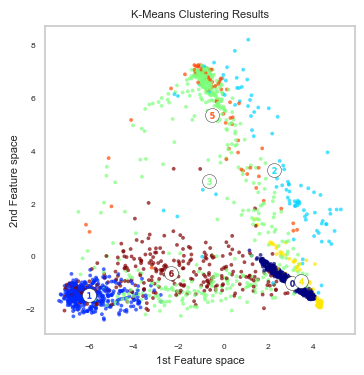

In [213]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 6, X_pca, gmm, ax, 'gmm')

In [214]:
sil_score = calculate_silhouette_score(X_pca, labels, 'euclidean')
sil_score = calculate_silhouette_score(X_pca, labels, 'cosine')

Silhouetter Score: 0.392
Silhouetter Score: 0.381


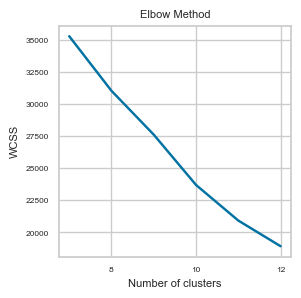

In [215]:
create_elbow_plot(7, 13, X_pca)

Model Selection

In [ ]:
# example grid search

param_grid = {n_components: [2, 5, 8, 10]} # easily add another parameter to this structure

grid_search = GridSearchCV(
    estimator=KMeans(random_state=42, n_init='auto'),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(X)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")